In [394]:
import numpy as np
import pandas as pd
import nltk
import re
import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


import gzip
import json
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

import string
# nltk.download('stopwords')
# nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)

from nltk.stem.snowball import SnowballStemmer
stemmer_snowball = SnowballStemmer('english')

from nltk.stem.porter import PorterStemmer
stemmer_porter = PorterStemmer()

from nltk import pos_tag

In [59]:
table=[]
with gzip.GzipFile("complete_data/Luxury_Beauty.json.gz", 'r') as f:   
    for line in f:
        table.append(json.loads(line))



In [214]:
df = pd.DataFrame(table)
df = df.drop(columns = ['reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime', 'style', 'image'], axis=0)
df = df[df['reviewText'].notnull()]

asin_list = df['asin'].unique()

# Test

In [292]:
df

,overall,vote,verified,asin,reviewText,summary
0,2.0,3,True,B00004U9V2,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work
1,5.0,14,True,B00004U9V2,"Believe me, over the years I have tried many, ...",Best hand cream ever.
2,5.0,NaN,True,B00004U9V2,Great hand lotion,Five Stars
3,5.0,NaN,True,B00004U9V2,This is the best for the severely dry skin on ...,Five Stars
4,5.0,NaN,True,B00004U9V2,The best non- oily hand cream ever. It heals o...,I always have a backup ready.
...,...,...,...,...,...,...
574623,5.0,NaN,True,B01HIQEOLO,Great color and I prefer shellac over gel,Five Stars
574624,5.0,NaN,True,B01HIQEOLO,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used
574625,5.0,NaN,True,B01HIQEOLO,Great polish and beautiful color!!,Great polish!
574626,1.0,2,True,B01HJ2UY0W,"The perfume is good, but the spray head broke ...",Spray head broke off within a month


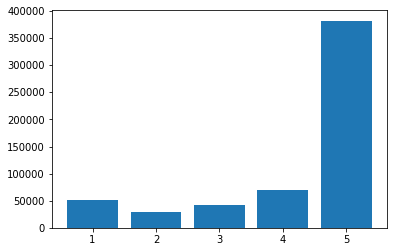

In [294]:
def product_rating(table):
    one = table[table['overall']==1.0].reset_index(inplace=False, drop=True)
    two = table[table['overall']==2.0].reset_index(inplace=False, drop=True)
    three = table[table['overall']==3.0].reset_index(inplace=False, drop=True)
    four = table[table['overall']==4.0].reset_index(inplace=False, drop=True)
    five = table[table['overall']==5.0].reset_index(inplace=False, drop=True)
    
    labels = ['1', '2', '3', '4', '5']
    y = [len(df_one), len(df_two), len(df_three), len(df_four), len(df_five)]
    plt.bar(labels, y);
    return one, two, three, four, five
df_one, df_two, df_three, df_four, df_five = product_rating(df)

In [300]:
df_one['reviewText']

0        SOOOO not worth the money. Packaging is aweful...
1        I have used this cream for decades, but this p...
2        This smells like mens cologne. I thought it wo...
3        Maybe Im just not familiar with this brand, bu...
4        Love this lotion but it arrived dented all ove...
                               ...                        
50472    what is your return policy, I do not see any o...
50473    Wow..... I bought this product for my daughter...
50474    I bought this in December and loved how my hai...
50475    DO NOT BUY!! I bought the mit to help spread t...
50476    The perfume is good, but the spray head broke ...
Name: reviewText, Length: 50477, dtype: object

In [305]:
def tokenize(df):
    final = []
    df_one = df['reviewText']
    
    for i in tqdm(range(len(df_one))):
        start_stemming = clean_data(df_one[i])
        final.append(stemming_tagging(start_stemming))
    return final
    
tokenize(df_one)

100%|██████████| 50477/50477 [01:20<00:00, 623.49it/s]


[[['soooo', 'worth', 'money'],
  ['packag', 'awe'],
  ['screw', 'top', 'way', 'small', 'hand', 'cream', 'paint'],
  ['felt', 'greasi', 'although', 'review', 'said', 'would'],
  ['disappoint']],
 [['use',
   'cream',
   'decad',
   'particular',
   'cream',
   'noth',
   'like',
   'old',
   'one'],
  ['old', 'cream', 'appeal', 'soft', 'scent'],
  ['one', 'offens', 'male', 'cologn', 'smell'],
  ['strong', 'wash', 'hand', 'immedi'],
  ['old', 'cream', 'visibl', 'hydrat', 'skin'],
  ['one'],
  ['guess', 'cream', 'cheap', 'knockoff'],
  ['wast', 'money']],
 [['smell', 'like', 'men', 'cologn'],
  ['thought', 'would', 'smell', 'feminin', 'disappoint']],
 [['mayb',
   'im',
   'familiar',
   'brand',
   'type',
   'fragranc',
   'normal',
   'use',
   '...',
   'blech',
   'might',
   'good',
   'cream',
   'wash',
   'hand',
   'immedi',
   'twice',
   'get',
   'horribl',
   'smell',
   'hand',
   'tell']],
 [['love', 'lotion', 'arriv', 'dent'], ['plan', 'give', 'gift', 'keep']],
 [['littl'

In [311]:
test = df_one['reviewText'][0]
test

'SOOOO not worth the money. Packaging is aweful. Screw top way too small and this is hand cream not paint. Felt greasy although the review said it would not. Disappointed.'

In [388]:
def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_])

def combine_list(lists):
    flat_list = []
    for sublist in lists:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def stemming(clean_data):
    _list = []
    ps = nltk.stem.SnowballStemmer('english')
    for i in clean_data:
        _list.append(ps.stem(i))
    return _list

def clean_data(string):
    alphabets = list(map(chr, range(97, 97+26))) + ["."]
    input_string = [c if c in alphabets else ' ' for c in string.lower()] 
    input_string = "".join(input_string)
    input_string = input_string.replace(' . ', '')
    input_string = re.sub(' +', ' ', input_string)
    
    sent_tokens = sent_tokenize(input_string)
    tokens = [sent for sent in map(word_tokenize, sent_tokens)]
    tokens_filtered = list(map(filter_tokens, tokens))

    tokens_combine = combine_list(tokens_filtered)
    
    stem = stemming(tokens_combine)

    return stem




In [389]:
clean_data(test)

['soooo',
 'worth',
 'money',
 'packag',
 'awe',
 'screw',
 'top',
 'way',
 'small',
 'hand',
 'cream',
 'paint',
 'felt',
 'greasi',
 'although',
 'review',
 'said',
 'would',
 'disappoint']

In [391]:
def get_word_matrix(df_one):
    final_list = []
    for i in tqdm(range(len(df_one['reviewText']))):
        temp = df_one['reviewText'][i]
        final_list.append(clean_data(temp))
    return final_list
get_word_matrix(df_one)

100%|██████████| 50477/50477 [01:21<00:00, 616.81it/s]


In [392]:
final_list

[['soooo',
  'worth',
  'money',
  'packag',
  'awe',
  'screw',
  'top',
  'way',
  'small',
  'hand',
  'cream',
  'paint',
  'felt',
  'greasi',
  'although',
  'review',
  'said',
  'would',
  'disappoint'],
 ['use',
  'cream',
  'decad',
  'particular',
  'cream',
  'noth',
  'like',
  'old',
  'one',
  'old',
  'cream',
  'appeal',
  'soft',
  'scent',
  'one',
  'offens',
  'male',
  'cologn',
  'smell',
  'strong',
  'wash',
  'hand',
  'immedi',
  'old',
  'cream',
  'visibl',
  'hydrat',
  'skin',
  'one',
  'guess',
  'cream',
  'cheap',
  'knockoff',
  'wast',
  'money'],
 ['smell',
  'like',
  'men',
  'cologn',
  'thought',
  'would',
  'smell',
  'feminin',
  'disappoint'],
 ['mayb',
  'im',
  'familiar',
  'brand',
  'type',
  'fragranc',
  'normal',
  'use',
  '...',
  'blech',
  'might',
  'good',
  'cream',
  'wash',
  'hand',
  'immedi',
  'twice',
  'get',
  'horribl',
  'smell',
  'hand',
  'tell'],
 ['love', 'lotion', 'arriv', 'dent', 'plan', 'give', 'gift', 'kee

In [395]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(final_list)

print(cv.get_feature_names())
print(cv_fit.toarray())

AttributeError: 'list' object has no attribute 'lower'

# Test File: Product B00004U9V2

In [288]:
test = df[df['asin'] == 'B00004U9V2'].reset_index(inplace=False, drop=True)


In [289]:
test

,overall,vote,verified,asin,reviewText,summary
0,2.0,3,True,B00004U9V2,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work
1,5.0,14,True,B00004U9V2,"Believe me, over the years I have tried many, ...",Best hand cream ever.
2,5.0,NaN,True,B00004U9V2,Great hand lotion,Five Stars
3,5.0,NaN,True,B00004U9V2,This is the best for the severely dry skin on ...,Five Stars
4,5.0,NaN,True,B00004U9V2,The best non- oily hand cream ever. It heals o...,I always have a backup ready.
...,...,...,...,...,...,...
576,3.0,NaN,True,B00004U9V2,I love this lotion. Part of the appeal is the...,Beautiful bottles arrived with multiple dents
577,5.0,NaN,True,B00004U9V2,"This is my favorite scent of this line, becaus...",lovely scent
578,4.0,NaN,True,B00004U9V2,Pleasant sent and softens skin.,Four Stars
579,5.0,NaN,True,B00004U9V2,This is my fave hand lotion. I have very oily ...,I have very oily hands and this stuff doesn't ...


In [291]:
one = test[test['overall']==1.0].reset_index(inplace=False, drop=True)
one

,overall,vote,verified,asin,reviewText,summary
0,1.0,NaN,True,B00004U9V2,SOOOO not worth the money. Packaging is aweful...,Disappointed.
1,1.0,NaN,True,B00004U9V2,"I have used this cream for decades, but this p...",Stinky Fake
2,1.0,NaN,True,B00004U9V2,This smells like mens cologne. I thought it wo...,One Star
3,1.0,NaN,False,B00004U9V2,"Maybe Im just not familiar with this brand, bu...",Bad fragrance
4,1.0,NaN,True,B00004U9V2,Love this lotion but it arrived dented all ove...,"Great product, dented container"
5,1.0,NaN,True,B00004U9V2,Too little for the cost.,One Star
6,1.0,NaN,False,B00004U9V2,testor's version,One Star
7,1.0,2,True,B00004U9V2,The bottle arrived with multiple dents.,"Great product, lousy packaging."
8,1.0,10,True,B00004U9V2,I used to love this lotion. It's one of the fe...,Disappointed
9,1.0,NaN,True,B00004U9V2,Bottle arrived dented. No packing slip. $30 wa...,One Star


In [273]:
def product_rating(table):
    one = [rate for rate in table if rate['overall'] == 1.0]
    two = [rate for rate in table if rate['overall'] == 2.0]
    three = [rate for rate in table if rate['overall'] == 3.0]
    four = [rate for rate in table if rate['overall'] == 4.0]
    five = [rate for rate in table if rate['overall'] == 5.0]
    
    labels = ['1', '2', '3', '4', '5']
    y = [len(df_one), len(df_two), len(df_three), len(df_four), len(df_five)]
    plt.bar(labels, y);
    return one, two, three, four, five
df_one, df_two, df_three, df_four, df_five = product_rating(test)

TypeError: string indices must be integers

In [263]:
def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_])

def clean_data(string):
    alphabets = list(map(chr, range(97, 97+26))) + ["."]
    input_string = [c if c in alphabets else ' ' for c in string.lower()] 
    input_string = "".join(input_string)
    input_string = input_string.replace(' . ', '')
    input_string = re.sub(' +', ' ', input_string)
    
    sent_tokens = sent_tokenize(input_string)
    tokens = [sent for sent in map(word_tokenize, sent_tokens)]
    tokens_filtered = list(map(filter_tokens, tokens))
    return tokens_filtered


def stemming_tagging(start_stemming):
    tokens_stemsnowball = [list(map(stemmer_snowball.stem, sent)) for sent in start_stemming]
    
    return  tokens_stemsnowball

start_stemming = clean_data(review_text[0])
stemming_tagging(start_stemming)

In [269]:
review_text[0]

"I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable."

In [268]:

def stemming_tagging(start_stemming):
    tokens_stemsnowball = [list(map(stemmer_snowball.stem, sent)) for sent in start_stemming]
    
    return  tokens_stemsnowball

start_stemming = clean_data(review_text[0])
stemming_tagging(start_stemming)


[['bought', 'two', 'fl', 'oz', 'hand', 'cream', 'neither', 'dispens', 'work'],
 ['hand',
  'cream',
  'wonder',
  'thick',
  'see',
  'get',
  'much',
  'shake',
  'sinc',
  'dispens',
  'seem',
  'non',
  'oper']]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import IPython.display
IPython.display.set_matplotlib_formats('svg')

wc = WordCloud(background_color="white",
               width=1000, height=1000,
               max_words=100, relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(document_counts[5])

fig, ax = plt.subplots(figsize=(12, 12))

ax.axis('off')

ax.imshow(wc);


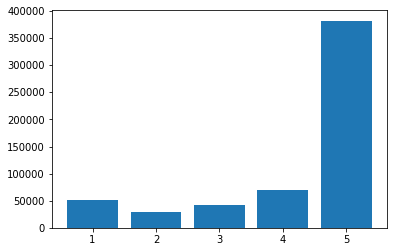

In [105]:
def product_rating(table):
    one = [rate for rate in table if rate['overall'] == 1.0]
    two = [rate for rate in table if rate['overall'] == 2.0]
    three = [rate for rate in table if rate['overall'] == 3.0]
    four = [rate for rate in table if rate['overall'] == 4.0]
    five = [rate for rate in table if rate['overall'] == 5.0]
    
    labels = ['1', '2', '3', '4', '5']
    y = [len(df_one), len(df_two), len(df_three), len(df_four), len(df_five)]
    plt.bar(labels, y);
    return one, two, three, four, five
df_one, df_two, df_three, df_four, df_five = product_rating(table)